# Function Testing Notebook (Windows) - Joseph

This notebook is meant to test external-facing functions to ensure they are working as expected.

A dedicated test_all_functions.py with unit testing might be better, but this is a good benchmark

In [1]:
import sys
from pathlib import Path
import time
import tempfile
import logging

import numpy as np
import matplotlib.pyplot as plt
import mne
import matplotlib.colors as colors
import scipy.stats


In [2]:
packageroot = Path('../../').resolve()
print(packageroot)
sys.path.append(str(packageroot))

from pythoneeg import core
from pythoneeg import visualization
# from pythoneeg import constants

print(core.__all__)
# print(visualization.__all__)
# print(dir(constants))

C:\Users\User\source-code\PyEEG


c:\Users\User\source-code\PyEEG\.venv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


['DDFBinaryMetadata', 'LongRecordingOrganizer', 'convert_ddfcolbin_to_ddfrowbin', 'convert_ddfrowbin_to_si', 'convert_units_to_multiplier', 'convert_colpath_to_rowpath', 'filepath_to_index', 'is_day', 'set_temp_directory', 'get_temp_directory', 'parse_path_to_animalday', 'parse_path_to_genotype', 'parse_path_to_animal', 'parse_path_to_day', 'parse_chname_to_abbrev', 'nanaverage', 'LongRecordingAnalyzer', 'MountainSortAnalyzer', 'FragmentAnalyzer']


In [3]:
core.utils.set_temp_directory(str(packageroot / 'tmp'))

In [4]:
tmpmet = core.DDFBinaryMetadata(packageroot / Path(r'notebooks\tests\test-data\A10 KO 12_13_2023\Cage 2 A10-0_Meta.csv'))
print(tmpmet.dt_end.ctime())
display(tmpmet.channel_names)

Wed Dec 13 11:17:32 2023


['Intan Input (1)/PortC C-009',
 'Intan Input (1)/PortC C-010',
 'Intan Input (1)/PortC C-012',
 'Intan Input (1)/PortC C-014',
 'Intan Input (1)/PortC C-015',
 'Intan Input (1)/PortC C-016',
 'Intan Input (1)/PortC C-017',
 'Intan Input (1)/PortC C-019',
 'Intan Input (1)/PortC C-021',
 'Intan Input (1)/PortC C-022']

In [5]:
data_folder = Path('./test-data').resolve()
lrec = core.LongRecordingOrganizer(base_folder_path= data_folder / 'A10 KO 12_13_2023',
                                    truncate=3)
lrec.convert_colbins_to_rowbins(overwrite=False)
lrec.convert_rowbins_to_rec()

C:\Users\User\source-code\PyEEG\pythoneeg\core\core.py:153: UserWarning: truncate = True. Only the first 3 files of each animal will be used
  warnings.warn(f"truncate = True. Only the first {self.n_truncate} files of each animal will be used")


In [6]:
Path('./test-wars/A5').resolve()

WindowsPath('C:/Users/User/source-code/PyEEG/notebooks/tests/test-wars/A5')

In [7]:
from dask.distributed import LocalCluster, Client

# Start a local cluster with 3 worker nodes
cluster = LocalCluster(n_workers=3, 
                       processes=True, 
                       threads_per_worker=1, 
                    #    memory_limit='1G',
                       )
# cluster = LocalCluster(n_workers=3, threads_per_worker=2, memory_limit='1G')
# cluster = LocalCluster(n_workers=3, threads_per_worker=3, memory_limit='1G')
client = Client(cluster)
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 3
Total threads: 3,Total memory: 31.70 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:60582,Workers: 3
Dashboard: http://127.0.0.1:8787/status,Total threads: 3
Started: Just now,Total memory: 31.70 GiB
Comm: tcp://127.0.0.1:60597,Total threads: 1
Dashboard: http://127.0.0.1:60598/status,Memory: 10.57 GiB
Nanny: tcp://127.0.0.1:60585,


In [8]:
# animal_ids = ['A5', 'A10', 'F22', 'G25']
animal_ids = ['A5']
# animal_ids = ['A10']
# animal_ids = ['F22']
# animal_ids = ['G25']
base_folder = Path('./test-data').resolve()
# base_folder = Path('/mnt/isilon/marsh_single_unit/PythonEEG Data Bins').resolve()
for animal_id in animal_ids:
    ao = visualization.AnimalOrganizer(base_folder, animal_id, mode="concat", assume_from_number=True, truncate=1)
    ao.convert_colbins_to_rowbins(overwrite=False)
    ao.convert_rowbins_to_rec(multiprocess_mode='serial')

    war = ao.compute_windowed_analysis(['all'], multiprocess_mode='dask')
        # war.to_pickle_and_json(Path(f'./test-wars/{animal_id}').resolve())

    sar = ao.compute_spike_analysis(multiprocess_mode='dask')
    

C:\Users\User\source-code\PyEEG\pythoneeg\core\core.py:153: UserWarning: truncate = True. Only the first 1 files of each animal will be used
  warnings.warn(f"truncate = True. Only the first {self.n_truncate} files of each animal will be used")
Converting row bins to recs: 100%|██████████| 1/1 [00:00<00:00,  4.53it/s]


Channel names: 	['Intan Input (1)/PortB L Aud Ctx', 'Intan Input (1)/PortB L Vis Ctx', 'Intan Input (1)/PortB L Hipp', 'Intan Input (1)/PortB L Barrel', 'Intan Input (1)/PortB L Motor', 'Intan Input (1)/PortB R Motor', 'Intan Input (1)/PortB R Barrel', 'Intan Input (1)/PortB R Hipp', 'Intan Input (1)/PortB R Vis Ctx', 'Intan Input (1)/PortB R Aud Ctx']
Channel abbreviations: 	['LAud', 'LVis', 'LHip', 'LBar', 'LMot', 'RMot', 'RBar', 'RHip', 'RVis', 'RAud']


In [9]:
display(war.get_result(['all'], allow_missing=True).head(2))
display(war.get_result(['all'], allow_missing=True).tail(2))

,index,animalday,animal,day,genotype,duration,endfile,timestamp,isday,rms,ampvar,psd,psdtotal,psdband,psdfrac,psdslope,cohere,pcorr
0,0,A5 WT Dec-12-2023,A5,2023-12-12,WT,4.0,None,2023-12-12 12:49:13.680,True,"[340.2445, 323.54434, 392.14343, 287.55704, 34...","[108016.54, 101200.21, 152518.36, 81025.01, 11...","([0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0,...","[5597.8659128090785, 5873.390229194629, 23754....","{'delta': [4002.5935854649256, 4266.2765370048...","{'delta': [0.7150213398835011, 0.7263737586851...","[[-2.2393311461395293, 4.016004230917379], [-2...","{'delta': [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
1,1,A5 WT Dec-12-2023,A5,2023-12-12,WT,4.0,None,2023-12-12 12:49:17.680,True,"[355.00095, 355.70462, 937.7705, 527.04816, 49...","[125480.39, 126022.64, 879195.4, 277070.97, 24...","([0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0,...","[59951.10843858841, 60773.262363882495, 616190...","{'delta': [20599.01035910109, 21049.6836566085...","{'delta': [0.34359682240407474, 0.346364220676...","[[-2.208425704608227, 5.1220083926827265], [-2...","{'delta': [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."


,index,animalday,animal,day,genotype,duration,endfile,timestamp,isday,rms,ampvar,psd,psdtotal,psdband,psdfrac,psdslope,cohere,pcorr
114,114,A5 WT Dec-12-2023,A5,2023-12-12,WT,4.0,None,2023-12-12 12:56:49.680,True,"[80.223114, 78.793945, 110.29962, 87.620056, 9...","[6435.7383, 6208.429, 12165.886, 7676.6177, 93...","([0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0,...","[4826.298505176893, 4021.675558692917, 10682.5...","{'delta': [955.6735448704175, 1214.63345325702...","{'delta': [0.19801376641857552, 0.302021740821...","[[-1.0743844564769316, 2.965038915081903], [-1...","{'delta': [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
115,115,A5 WT Dec-12-2023,A5,2023-12-12,WT,4.0,None,2023-12-12 12:56:53.680,True,"[98.042915, 89.903175, 125.526146, 100.010666,...","[9612.304, 8081.1436, 15756.788, 9994.47, 1084...","([0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0,...","[6157.168776712644, 4000.8900308516368, 11346....","{'delta': [704.5873149940397, 1914.95702302186...","{'delta': [0.1144336529573295, 0.4786327562755...","[[-1.0265161926976187, 3.0569340649083316], [-...","{'delta': [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."


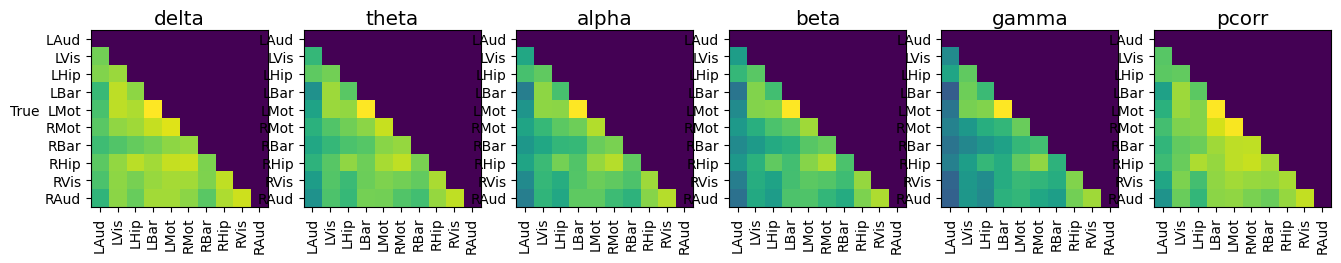

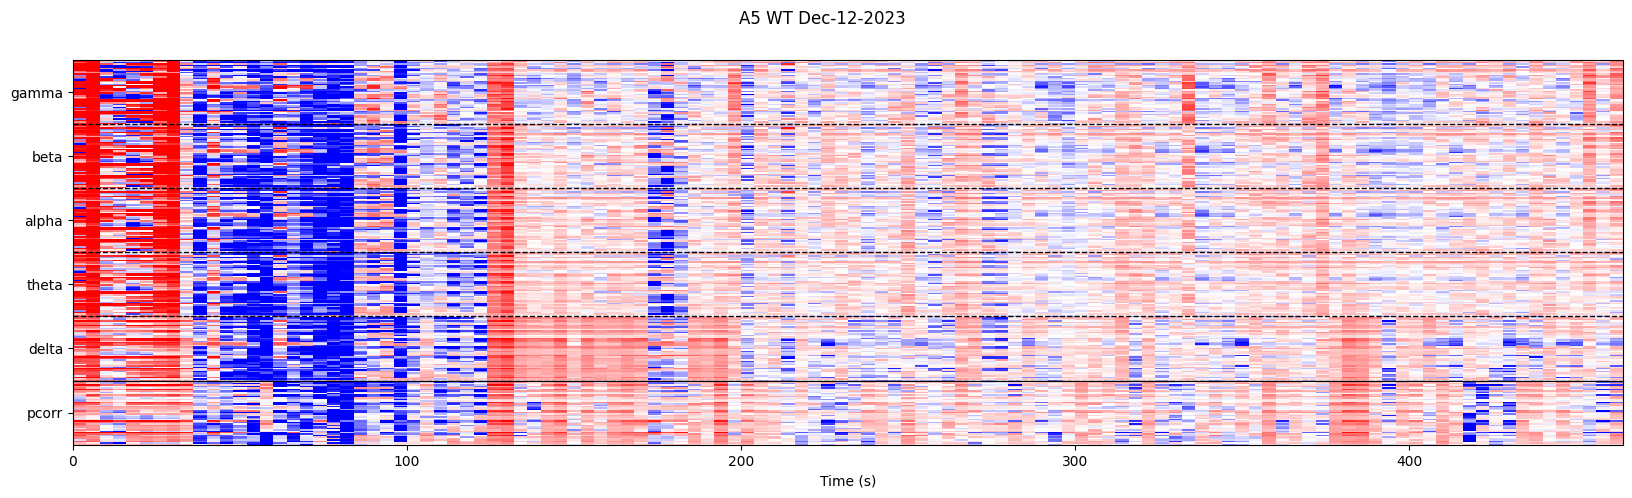

C:\Users\User\source-code\PyEEG\pythoneeg\visualization\plotting\animal.py:326: RuntimeWarning: divide by zero encountered in log10
  ax[0, i].plot(freqs, 10**(b + m * np.log10(freqs)), c=f'C{j}', alpha=0.75)


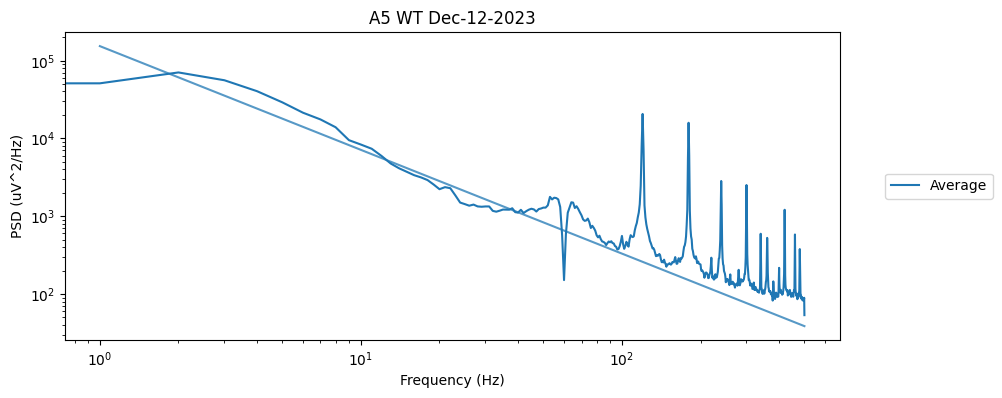

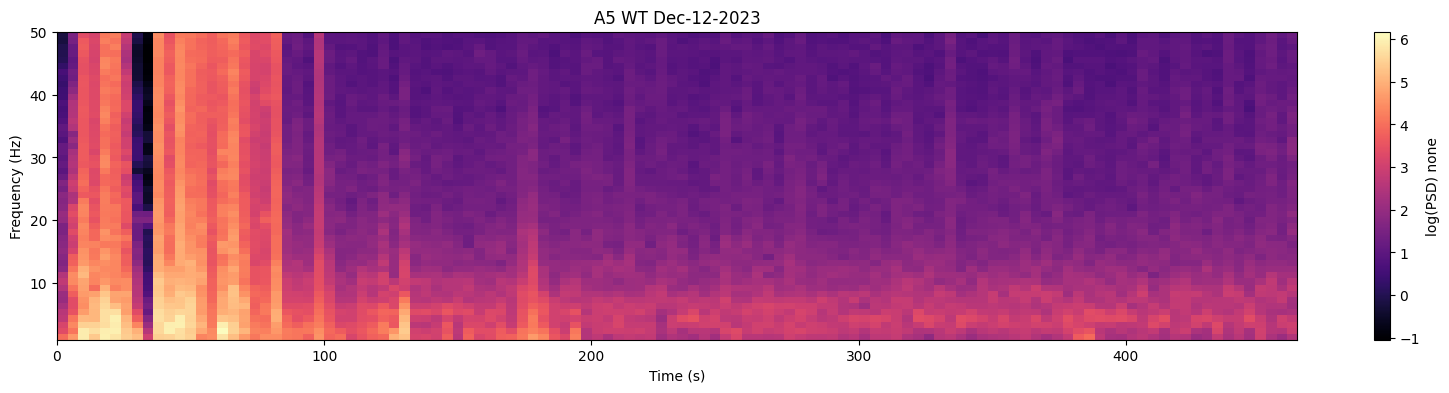

In [10]:
ap = visualization.AnimalPlotter(war)
ap.plot_coherecorr_matrix(['isday'], bands=None, figsize=(16,5), cmap='viridis')
# ap.plot_coherecorr_diff(['isday'], bands=None, figsize=(16,5))
# ap.plot_linear_temporal(figsize=(20, 5), score_type='z', lw=1, channels=[0, 1])
# ap.plot_linear_temporal(['isday'], figsize=(20, 5), score_type='z', lw=1, channels=[0, 1, 2, 3])

# ap.plot_coherecorr_spectral(['isday'], figsize=(20, 5), score_type='center')

ap.plot_coherecorr_spectral(figsize=(20, 5), score_type='center')
ap.plot_psd_histogram(figsize=(10, 4), avg_channels=True, plot_type='loglog')
ap.plot_psd_spectrogram(figsize=(20, 4), mode='none')

In [11]:
logger = logging.getLogger()
logger.setLevel(logging.DEBUG)

INFO:root:get_filter_rms_range:	filtered 43/1170
INFO:root:get_filter_high_rms:	filtered 0/1170
INFO:root:get_filter_high_beta:	filtered 480/1170
DEBUG:root:Reject channels: [[ True  True  True ...  True  True  True]
 [ True  True  True ...  True  True  True]
 [ True  True  True ...  True  True  True]
 ...
 [ True  True  True ...  True  True  True]
 [ True  True  True ...  True  True  True]
 [ True  True  True ...  True  True  True]]
INFO:root:Filtering rms
INFO:root:Filtering ampvar
INFO:root:Filtering psd
INFO:root:Filtering psdtotal
INFO:root:Filtering psdband
INFO:root:Filtering psdfrac
INFO:root:Filtering psdslope
INFO:root:Filtering cohere
INFO:root:Filtering pcorr
INFO:root:channel_names: [['LAud', 'LVis', 'LHip', 'LBar', 'LMot', 'RMot', 'RBar', 'RHip', 'RVis', 'RAud'], ['LAud', 'LVis', 'LHip', 'LBar', 'LMot', 'RMot', 'RBar', 'RHip', 'RVis', 'RAud']]
INFO:root:channel_to_idx: [{'LAud': 0, 'LVis': 1, 'LHip': 2, 'LBar': 3, 'LMot': 4, 'RMot': 5, 'RBar': 6, 'RHip': 7, 'RVis': 8, 'RA

Channel names: 	['Intan Input (1)/PortC C-009', 'Intan Input (1)/PortC C-010', 'Intan Input (1)/PortC C-012', 'Intan Input (1)/PortC C-014', 'Intan Input (1)/PortC C-015', 'Intan Input (1)/PortC C-016', 'Intan Input (1)/PortC C-017', 'Intan Input (1)/PortC C-019', 'Intan Input (1)/PortC C-021', 'Intan Input (1)/PortC C-022']
Channel abbreviations: 	['LAud', 'LVis', 'LHip', 'LBar', 'LMot', 'RMot', 'RBar', 'RHip', 'RVis', 'RAud']
Channel names: 	['Intan Input (1)/PortD D-009', 'Intan Input (1)/PortD D-010', 'Intan Input (1)/PortD D-012', 'Intan Input (1)/PortD D-014', 'Intan Input (1)/PortD D-015', 'Intan Input (1)/PortD D-016', 'Intan Input (1)/PortD D-017', 'Intan Input (1)/PortD D-019', 'Intan Input (1)/PortD D-021', 'Intan Input (1)/PortD D-022']
Channel abbreviations: 	['LAud', 'LVis', 'LHip', 'LBar', 'LMot', 'RMot', 'RBar', 'RHip', 'RVis', 'RAud']
Channel names: 	['Intan Input (1)/PortD D-009', 'Intan Input (1)/PortD D-010', 'Intan Input (1)/PortD D-012', 'Intan Input (1)/PortD D-0

DEBUG:root:groups: [('A10', 'KO'), ('F22', 'KO')]
DEBUG:root:vals.shape: (31, 5, 10, 10)
DEBUG:root:vals.shape: (31, 5)
DEBUG:root:vals.shape: (117, 5, 10, 10)
C:\Users\User\source-code\PyEEG\pythoneeg\visualization\plotting\experiment.py:143: RuntimeWarning: Mean of empty slice
  vals = np.nanmean(vals[:, :, tril_indices[0], tril_indices[1]], axis=-1)
DEBUG:root:vals.shape: (117, 5)
DEBUG:root:groups: [('A10', 'KO'), ('F22', 'KO')]
DEBUG:root:vals.shape: (31, 5, 10, 10)
DEBUG:root:vals.shape: (31, 5, 10, 10)
DEBUG:root:vals.shape: (117, 5, 10, 10)
DEBUG:root:vals.shape: (117, 5, 10, 10)
DEBUG:matplotlib.colorbar:locator: <matplotlib.ticker.AutoLocator object at 0x0000028614E10460>
DEBUG:matplotlib.colorbar:locator: <matplotlib.ticker.AutoLocator object at 0x0000028614E629E0>
DEBUG:matplotlib.colorbar:locator: <matplotlib.ticker.AutoLocator object at 0x0000028614EA6140>
DEBUG:matplotlib.colorbar:locator: <matplotlib.ticker.AutoLocator object at 0x0000028614EF30A0>
DEBUG:matplotlib.colo

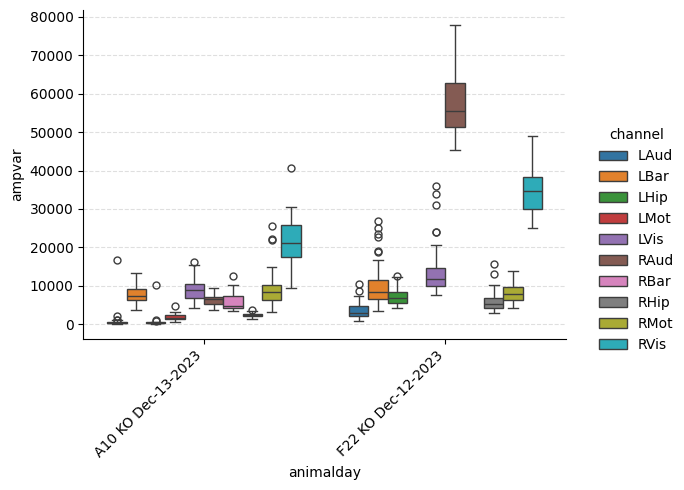

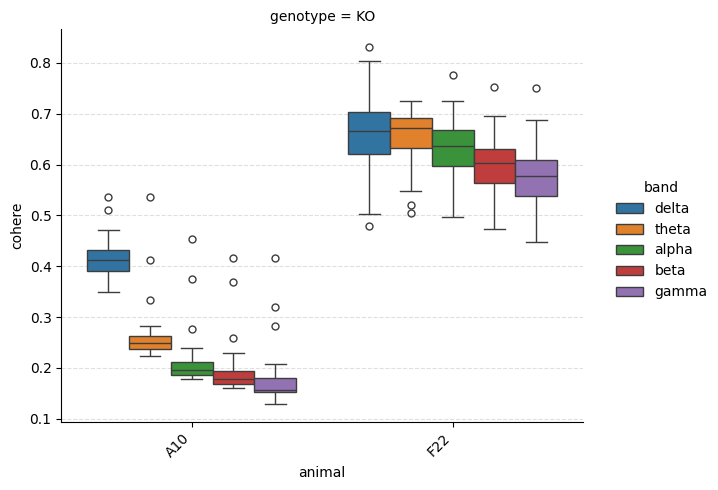

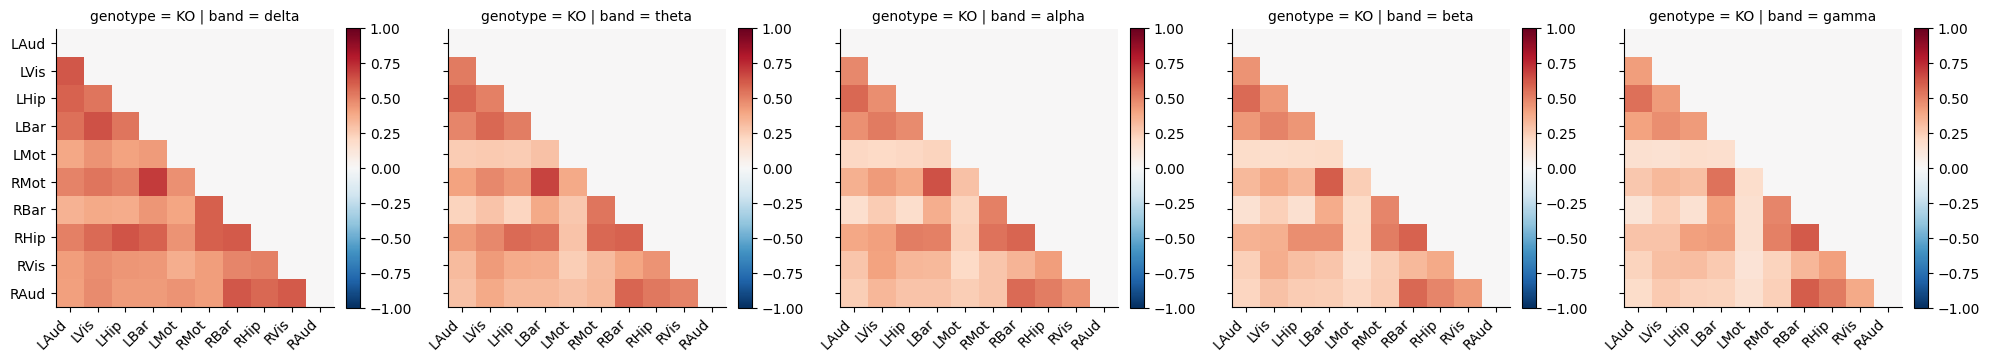

In [12]:
wars = []
animal_ids = ['A10', 'F22']
for animal_id in animal_ids:
    war = visualization.WindowAnalysisResult.load_pickle_and_json(Path(f'./test-wars/{animal_id}').resolve())
    if animal_id == 'F22':
        war.filter_all(reject_channels=['LMot', 'RBar'])
    wars.append(war)
ep = visualization.ExperimentPlotter(wars)


# display(ep._pull_timeseries_dataframe('pcorr', ['isday', 'animal'], collapse_channels=True))

ep.plot_catplot('ampvar', ['animalday'])
ep.plot_catplot('cohere', ['animal', 'genotype'], collapse_channels=True, hue='band')
ep.plot_matrixplot('cohere', ['animal', 'genotype'], col='band')

DEBUG:root:groups: ['A10', 'F22']
DEBUG:root:vals.shape: (31, 10, 5)
DEBUG:root:vals.shape: (117, 10, 5)
DEBUG:root:pairs: [(('A10', 'LAud'), ('F22', 'LAud')), (('A10', 'LBar'), ('F22', 'LBar')), (('A10', 'LHip'), ('F22', 'LHip')), (('A10', 'LMot'), ('F22', 'LMot')), (('A10', 'LVis'), ('F22', 'LVis')), (('A10', 'RAud'), ('F22', 'RAud')), (('A10', 'RBar'), ('F22', 'RBar')), (('A10', 'RHip'), ('F22', 'RHip')), (('A10', 'RMot'), ('F22', 'RMot')), (('A10', 'RVis'), ('F22', 'RVis'))]
DEBUG:statannotations._Plotter:rectangle width is larger than the typical group artist: 2.0
INFO:statannotations.compat:Cannot find group ('F22', 'LMot') for ['x', 'hue'] in data.
INFO:statannotations.compat:Cannot find group ('F22', 'RBar') for ['x', 'hue'] in data.
c:\Users\User\source-code\PyEEG\.venv\lib\site-packages\statannotations\stats\StatTest.py:77: SmallSampleWarning: One or more sample arguments is too small; all returned values will be NaN. See documentation for sample size requirements.
  stat, pv

p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

A10_RVis vs. F22_RVis: Mann-Whitney-Wilcoxon test two-sided, P_val:3.134e-15 U_stat=1.422e+04
A10_LAud vs. F22_LAud: Mann-Whitney-Wilcoxon test two-sided, P_val:1.093e-35 U_stat=7.627e+03
A10_LBar vs. F22_LBar: Mann-Whitney-Wilcoxon test two-sided, P_val:2.343e-01 U_stat=2.688e+04
A10_LHip vs. F22_LHip: Mann-Whitney-Wilcoxon test two-sided, P_val:1.475e-65 U_stat=9.620e+02
A10_LMot vs. F22_LMot: Mann-Whitney-Wilcoxon test two-sided, P_val:nan U_stat=nan
A10_LVis vs. F22_LVis: Mann-Whitney-Wilcoxon test two-sided, P_val:6.575e-04 U_stat=2.002e+04
A10_RAud vs. F22_RAud: Mann-Whitney-Wilcoxon test two-sided, P_val:1.468e-70 U_stat=1.400e+01
A10_RBar vs. F22_RBar: Mann-Whitney-Wilcoxon test two-sided, P_val:nan U_stat=nan
A10_RHip vs. F22_RHip: Mann-Whitney-Wilcoxon test two-sided, P_val:2.367e-14 U_s

DEBUG:root:pairs: [(('A10', 'LAud'), ('F22', 'LAud')), (('A10', 'LBar'), ('F22', 'LBar')), (('A10', 'LHip'), ('F22', 'LHip')), (('A10', 'LMot'), ('F22', 'LMot')), (('A10', 'LVis'), ('F22', 'LVis')), (('A10', 'RAud'), ('F22', 'RAud')), (('A10', 'RBar'), ('F22', 'RBar')), (('A10', 'RHip'), ('F22', 'RHip')), (('A10', 'RMot'), ('F22', 'RMot')), (('A10', 'RVis'), ('F22', 'RVis'))]
DEBUG:statannotations._Plotter:rectangle width is larger than the typical group artist: 1.98
INFO:statannotations.compat:Cannot find group ('F22', 'LMot') for ['x', 'hue'] in data.
INFO:statannotations.compat:Cannot find group ('F22', 'RBar') for ['x', 'hue'] in data.


A10_RMot vs. F22_RMot: Mann-Whitney-Wilcoxon test two-sided, P_val:5.809e-02 U_stat=2.830e+04
p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

A10_RVis vs. F22_RVis: Mann-Whitney-Wilcoxon test two-sided, P_val:3.134e-15 U_stat=1.422e+04


c:\Users\User\source-code\PyEEG\.venv\lib\site-packages\statannotations\stats\StatTest.py:77: SmallSampleWarning: One or more sample arguments is too small; all returned values will be NaN. See documentation for sample size requirements.
  stat, pval = self._func(group_data1, group_data2, *self.args,


A10_LAud vs. F22_LAud: Mann-Whitney-Wilcoxon test two-sided, P_val:1.093e-35 U_stat=7.627e+03
A10_LBar vs. F22_LBar: Mann-Whitney-Wilcoxon test two-sided, P_val:2.343e-01 U_stat=2.688e+04
A10_LHip vs. F22_LHip: Mann-Whitney-Wilcoxon test two-sided, P_val:1.475e-65 U_stat=9.620e+02
A10_LMot vs. F22_LMot: Mann-Whitney-Wilcoxon test two-sided, P_val:nan U_stat=nan
A10_LVis vs. F22_LVis: Mann-Whitney-Wilcoxon test two-sided, P_val:6.575e-04 U_stat=2.002e+04
A10_RAud vs. F22_RAud: Mann-Whitney-Wilcoxon test two-sided, P_val:1.468e-70 U_stat=1.400e+01
A10_RBar vs. F22_RBar: Mann-Whitney-Wilcoxon test two-sided, P_val:nan U_stat=nan
A10_RHip vs. F22_RHip: Mann-Whitney-Wilcoxon test two-sided, P_val:2.367e-14 U_stat=1.509e+04


DEBUG:root:pairs: [(('A10', 'LAud'), ('F22', 'LAud')), (('A10', 'LBar'), ('F22', 'LBar')), (('A10', 'LHip'), ('F22', 'LHip')), (('A10', 'LMot'), ('F22', 'LMot')), (('A10', 'LVis'), ('F22', 'LVis')), (('A10', 'RAud'), ('F22', 'RAud')), (('A10', 'RBar'), ('F22', 'RBar')), (('A10', 'RHip'), ('F22', 'RHip')), (('A10', 'RMot'), ('F22', 'RMot')), (('A10', 'RVis'), ('F22', 'RVis'))]
DEBUG:statannotations._Plotter:rectangle width is larger than the typical group artist: 1.9800000000000004
INFO:statannotations.compat:Cannot find group ('F22', 'LMot') for ['x', 'hue'] in data.
INFO:statannotations.compat:Cannot find group ('F22', 'RBar') for ['x', 'hue'] in data.


A10_RMot vs. F22_RMot: Mann-Whitney-Wilcoxon test two-sided, P_val:5.809e-02 U_stat=2.830e+04
p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

A10_RVis vs. F22_RVis: Mann-Whitney-Wilcoxon test two-sided, P_val:3.134e-15 U_stat=1.422e+04


c:\Users\User\source-code\PyEEG\.venv\lib\site-packages\statannotations\stats\StatTest.py:77: SmallSampleWarning: One or more sample arguments is too small; all returned values will be NaN. See documentation for sample size requirements.
  stat, pval = self._func(group_data1, group_data2, *self.args,


A10_LAud vs. F22_LAud: Mann-Whitney-Wilcoxon test two-sided, P_val:1.093e-35 U_stat=7.627e+03
A10_LBar vs. F22_LBar: Mann-Whitney-Wilcoxon test two-sided, P_val:2.343e-01 U_stat=2.688e+04
A10_LHip vs. F22_LHip: Mann-Whitney-Wilcoxon test two-sided, P_val:1.475e-65 U_stat=9.620e+02
A10_LMot vs. F22_LMot: Mann-Whitney-Wilcoxon test two-sided, P_val:nan U_stat=nan
A10_LVis vs. F22_LVis: Mann-Whitney-Wilcoxon test two-sided, P_val:6.575e-04 U_stat=2.002e+04
A10_RAud vs. F22_RAud: Mann-Whitney-Wilcoxon test two-sided, P_val:1.468e-70 U_stat=1.400e+01
A10_RBar vs. F22_RBar: Mann-Whitney-Wilcoxon test two-sided, P_val:nan U_stat=nan
A10_RHip vs. F22_RHip: Mann-Whitney-Wilcoxon test two-sided, P_val:2.367e-14 U_stat=1.509e+04
A10_RMot vs. F22_RMot: Mann-Whitney-Wilcoxon test two-sided, P_val:5.809e-02 U_stat=2.830e+04


DEBUG:root:pairs: [(('A10', 'LAud'), ('F22', 'LAud')), (('A10', 'LBar'), ('F22', 'LBar')), (('A10', 'LHip'), ('F22', 'LHip')), (('A10', 'LMot'), ('F22', 'LMot')), (('A10', 'LVis'), ('F22', 'LVis')), (('A10', 'RAud'), ('F22', 'RAud')), (('A10', 'RBar'), ('F22', 'RBar')), (('A10', 'RHip'), ('F22', 'RHip')), (('A10', 'RMot'), ('F22', 'RMot')), (('A10', 'RVis'), ('F22', 'RVis'))]
DEBUG:statannotations._Plotter:rectangle width is larger than the typical group artist: 1.9799999999999995
INFO:statannotations.compat:Cannot find group ('F22', 'LMot') for ['x', 'hue'] in data.
INFO:statannotations.compat:Cannot find group ('F22', 'RBar') for ['x', 'hue'] in data.
c:\Users\User\source-code\PyEEG\.venv\lib\site-packages\statannotations\stats\StatTest.py:77: SmallSampleWarning: One or more sample arguments is too small; all returned values will be NaN. See documentation for sample size requirements.
  stat, pval = self._func(group_data1, group_data2, *self.args,


p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

A10_RVis vs. F22_RVis: Mann-Whitney-Wilcoxon test two-sided, P_val:3.134e-15 U_stat=1.422e+04
A10_LAud vs. F22_LAud: Mann-Whitney-Wilcoxon test two-sided, P_val:1.093e-35 U_stat=7.627e+03
A10_LBar vs. F22_LBar: Mann-Whitney-Wilcoxon test two-sided, P_val:2.343e-01 U_stat=2.688e+04
A10_LHip vs. F22_LHip: Mann-Whitney-Wilcoxon test two-sided, P_val:1.475e-65 U_stat=9.620e+02
A10_LMot vs. F22_LMot: Mann-Whitney-Wilcoxon test two-sided, P_val:nan U_stat=nan
A10_LVis vs. F22_LVis: Mann-Whitney-Wilcoxon test two-sided, P_val:6.575e-04 U_stat=2.002e+04
A10_RAud vs. F22_RAud: Mann-Whitney-Wilcoxon test two-sided, P_val:1.468e-70 U_stat=1.400e+01
A10_RBar vs. F22_RBar: Mann-Whitney-Wilcoxon test two-sided, P_val:nan U_stat=nan
A10_RHip vs. F22_RHip: Mann-Whitney-Wilcoxon test two-sided, P_val:2.367e-14 U_s

DEBUG:root:pairs: [(('A10', 'LAud'), ('F22', 'LAud')), (('A10', 'LBar'), ('F22', 'LBar')), (('A10', 'LHip'), ('F22', 'LHip')), (('A10', 'LMot'), ('F22', 'LMot')), (('A10', 'LVis'), ('F22', 'LVis')), (('A10', 'RAud'), ('F22', 'RAud')), (('A10', 'RBar'), ('F22', 'RBar')), (('A10', 'RHip'), ('F22', 'RHip')), (('A10', 'RMot'), ('F22', 'RMot')), (('A10', 'RVis'), ('F22', 'RVis'))]
DEBUG:statannotations._Plotter:rectangle width is larger than the typical group artist: 1.9800000000000004
INFO:statannotations.compat:Cannot find group ('F22', 'LMot') for ['x', 'hue'] in data.
INFO:statannotations.compat:Cannot find group ('F22', 'RBar') for ['x', 'hue'] in data.


A10_RMot vs. F22_RMot: Mann-Whitney-Wilcoxon test two-sided, P_val:5.809e-02 U_stat=2.830e+04
p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

A10_RVis vs. F22_RVis: Mann-Whitney-Wilcoxon test two-sided, P_val:3.134e-15 U_stat=1.422e+04


c:\Users\User\source-code\PyEEG\.venv\lib\site-packages\statannotations\stats\StatTest.py:77: SmallSampleWarning: One or more sample arguments is too small; all returned values will be NaN. See documentation for sample size requirements.
  stat, pval = self._func(group_data1, group_data2, *self.args,


A10_LAud vs. F22_LAud: Mann-Whitney-Wilcoxon test two-sided, P_val:1.093e-35 U_stat=7.627e+03
A10_LBar vs. F22_LBar: Mann-Whitney-Wilcoxon test two-sided, P_val:2.343e-01 U_stat=2.688e+04
A10_LHip vs. F22_LHip: Mann-Whitney-Wilcoxon test two-sided, P_val:1.475e-65 U_stat=9.620e+02
A10_LMot vs. F22_LMot: Mann-Whitney-Wilcoxon test two-sided, P_val:nan U_stat=nan
A10_LVis vs. F22_LVis: Mann-Whitney-Wilcoxon test two-sided, P_val:6.575e-04 U_stat=2.002e+04
A10_RAud vs. F22_RAud: Mann-Whitney-Wilcoxon test two-sided, P_val:1.468e-70 U_stat=1.400e+01
A10_RBar vs. F22_RBar: Mann-Whitney-Wilcoxon test two-sided, P_val:nan U_stat=nan
A10_RHip vs. F22_RHip: Mann-Whitney-Wilcoxon test two-sided, P_val:2.367e-14 U_stat=1.509e+04
A10_RMot vs. F22_RMot: Mann-Whitney-Wilcoxon test two-sided, P_val:5.809e-02 U_stat=2.830e+04


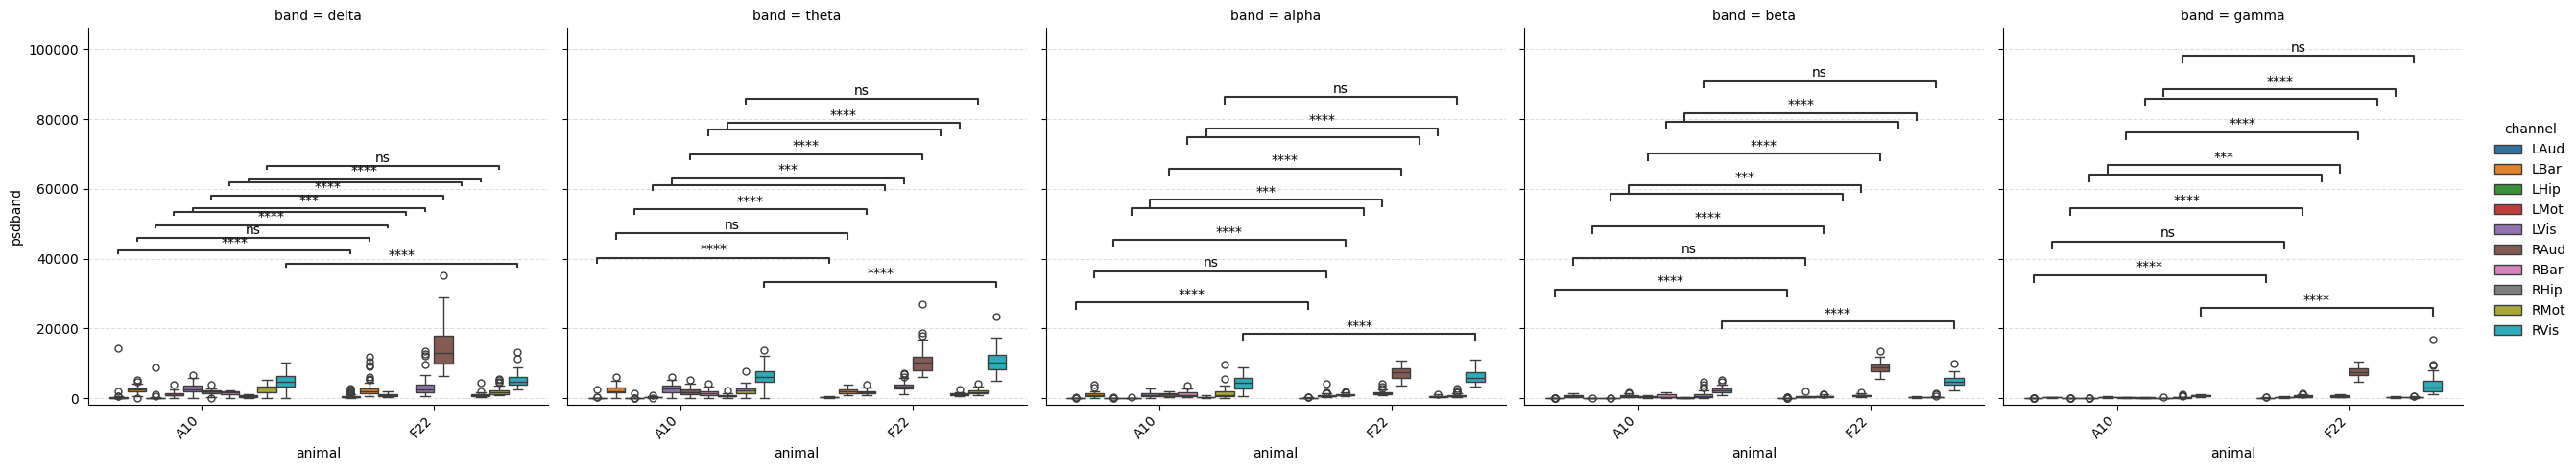

In [26]:
g = ep.plot_catplot('psdband', ['animal'], 
                    collapse_channels=False, hue='channel', col='band',
                    stat_pairs='x',
                    # stat_pairs=[[('A10 KO Dec-13-2023', 'theta'), ('F22 KO Dec-12-2023', 'delta')]],
                    # stat_pairs=[[('F22', 'delta'), ('F22', 'theta')], [('F22', 'theta'), ('A10', 'theta')]], 
                    # stat_pairs=[[('F22', 'delta'), ('F22', 'theta')], [('F22', 'theta'), ('A10', 'theta')]], 
                    # stat_pairs=perms,
                    # stat_test='Brunner-Munzel',
                    # norm_test='log-D-Agostino',
                    )
# ep.plot_catplot('ampvar', ['animalday'])
# ep.plot_catplot('psdfrac', ['animal', 'genotype'], collapse_channels=True, hue='band')
# ep.plot_catplot('psdfrac', ['isday', 'animalday'], hue='channel', x='animalday', col='band', cmap='viridis')
# ep.plot_catplot('psdband', ['isday', 'animalday'], hue='channel', x='animalday', col='isday', cmap='viridis')
# ep.plot_matrixplot('cohere', ['animalday', 'genotype'], col='band', row='animalday')


In [14]:
ep._construct_stat_pairs(df, groupby=['animal'])

AttributeError: 'ExperimentPlotter' object has no attribute '_construct_stat_pairs'

In [15]:
# sar[0].result
# visualization.SpikeAnalysisResult.convert_sas_to_mne(sar[0].result)

In [16]:
# Set up logger with detailed formatting
logging.basicConfig(format='%(asctime)s - %(levelname)s - %(message)s', level=logging.DEBUG)
logger = logging.getLogger()

In [17]:
def analyze_peri_spike_tfr(mne_obj, tmin=-10, tmax=10, l_freq=0.1, h_freq=100):
    """
    Analyze time-frequency representation around spikes from an MNE object.
    
    Parameters:
    -----------
    mne_obj : mne.io.Raw
        The MNE object containing the data and spike annotations
    tmin : float
        Start time relative to spike (in seconds)
    tmax : float
        End time relative to spike (in seconds)
    l_freq : float
        Lower frequency bound for filtering
    h_freq : float
        Upper frequency bound for filtering
    """
    raw = mne_obj.copy()
    events, event_dict = mne.events_from_annotations(raw=raw)
    
    # Common parameters for epoch creation
    epoch_params = {
        'raw': raw,
        'preload': True,
        'baseline': None,
        'event_repeated': 'drop'
    }
    
    # Process each spike type separately
    for unit_id in event_dict.keys():
        print(f"Processing unit: {unit_id}")
        
        # Create spike-centered epochs
        epochs_spike = mne.Epochs(
            **epoch_params,
            event_id={unit_id: event_dict[unit_id]},
            tmin=tmin,
            tmax=tmax
        )
        epochs_spike.filter(l_freq=l_freq, h_freq=h_freq)
        fig = mne.viz.plot_epochs_image(epochs_spike, picks=list(range(len(raw.ch_names))), show=False) # Do not combine channels
        plt.show()
        
        # Create baseline epochs from whole recording
        epochs_baseline = mne.make_fixed_length_epochs(
            raw, 
            duration=tmax-tmin,
            preload=True
        )
        epochs_baseline.filter(l_freq=l_freq, h_freq=h_freq)
        
        # Ensure we have comparable numbers of epochs
        n_epochs = min(len(epochs_spike), len(epochs_baseline))
        if n_epochs < 1:
            print(f"No valid epochs for unit {unit_id}")
            continue
            
        epochs_spike = epochs_spike[:n_epochs]
        epochs_baseline = epochs_baseline[:n_epochs]
        
        # Compute time-frequency representation
        tfr_params = dict(
            freqs=np.arange(l_freq, h_freq, 1),
            n_cycles=np.arange(l_freq, h_freq, 1) * 2,
            method='multitaper',
            use_fft=True,
            average=True
        )
        
        print("Computing TFR...")
        tfr_spike = epochs_spike.compute_tfr(**tfr_params)
        tfr_baseline = epochs_baseline.compute_tfr(**tfr_params)
        
        # Plot the results
        plot_tfr_ratio(tfr_spike, tfr_baseline)
        
        return tfr_spike, tfr_baseline

def plot_tfr_ratio(tfr_spike, tfr_baseline):
    """Plot the ratio between spike and baseline TFR."""
    pow_baseline = np.mean(tfr_baseline.get_data(), axis=(0, 2))
    pow_baseline = pow_baseline[:, np.newaxis]
    pow_spike, plot_t, plot_f = tfr_spike.get_data(return_times=True, return_freqs=True)
    pow_spike = np.mean(pow_spike, axis=0)
    pow_ratio = pow_spike / pow_baseline
    
    fig, ax = plt.subplots(1, 1, figsize=(7, 4))
    im = ax.imshow(pow_ratio, aspect='auto',
                   extent=[plot_t[0], plot_t[-1], plot_f[0], plot_f[-1]],
                   origin='lower',
                   cmap=plt.cm.RdBu_r,
                   norm=colors.TwoSlopeNorm(vmin=0.5, vcenter=1, vmax=10))
    
    ax.set_xlabel('Time (s)')
    ax.set_ylabel('Frequency (Hz)')
    ax.axvline(0, color='black', linestyle='--')
    plt.colorbar(im, ax=ax, label='Power Ratio (spike/baseline)')
    plt.show()


In [18]:
# Example usage:
mne_obj: mne.io.RawArray = visualization.SpikeAnalysisResult.convert_sas_to_mne(sar[0].result_sas)

DEBUG:root:Converting channel 0 of 10
DEBUG:root:Recording info: ChannelSliceRecording: 1 channels - 1000.0Hz - 1 segments - 466,320 samples 
                       466.32s (7.77 minutes) - float32 dtype - 1.78 MiB
DEBUG:root:Converting channel 1 of 10
DEBUG:root:Recording info: ChannelSliceRecording: 1 channels - 1000.0Hz - 1 segments - 466,320 samples 
                       466.32s (7.77 minutes) - float32 dtype - 1.78 MiB
DEBUG:root:Converting channel 2 of 10
DEBUG:root:Recording info: ChannelSliceRecording: 1 channels - 1000.0Hz - 1 segments - 466,320 samples 
                       466.32s (7.77 minutes) - float32 dtype - 1.78 MiB
DEBUG:root:Converting channel 3 of 10
DEBUG:root:Recording info: ChannelSliceRecording: 1 channels - 1000.0Hz - 1 segments - 466,320 samples 
                       466.32s (7.77 minutes) - float32 dtype - 1.78 MiB
DEBUG:root:Converting channel 4 of 10
DEBUG:root:Recording info: ChannelSliceRecording: 1 channels - 1000.0Hz - 1 segments - 466,320 samples

Creating RawArray with float64 data, n_channels=10, n_times=466320
    Range : 0 ... 466319 =      0.000 ...   466.319 secs
Ready.


Used Annotations descriptions: [np.str_('Intan Input (1)/PortB L Aud Ctx'), np.str_('Intan Input (1)/PortB L Barrel'), np.str_('Intan Input (1)/PortB L Hipp'), np.str_('Intan Input (1)/PortB L Motor'), np.str_('Intan Input (1)/PortB L Vis Ctx'), np.str_('Intan Input (1)/PortB R Aud Ctx'), np.str_('Intan Input (1)/PortB R Barrel'), np.str_('Intan Input (1)/PortB R Hipp'), np.str_('Intan Input (1)/PortB R Motor'), np.str_('Intan Input (1)/PortB R Vis Ctx')]


DEBUG:matplotlib.font_manager:findfont: Matching sans\-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=8.33.
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='c:\\Users\\User\\source-code\\PyEEG\\.venv\\lib\\site-packages\\matplotlib\\mpl-data\\fonts\\ttf\\STIXGeneralBolIta.ttf', name='STIXGeneral', style='italic', variant='normal', weight=700, stretch='normal', size='scalable')) = 11.335
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='c:\\Users\\User\\source-code\\PyEEG\\.venv\\lib\\site-packages\\matplotlib\\mpl-data\\fonts\\ttf\\DejaVuSansDisplay.ttf', name='DejaVu Sans Display', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='c:\\Users\\User\\source-code\\PyEEG\\.venv\\lib\\site-packages\\matplotlib\\mpl-data\\fonts\\ttf\\DejaVuSansMono-BoldOblique.ttf', name='DejaVu Sans Mono', style='oblique', variant='normal', weight=700, stretc

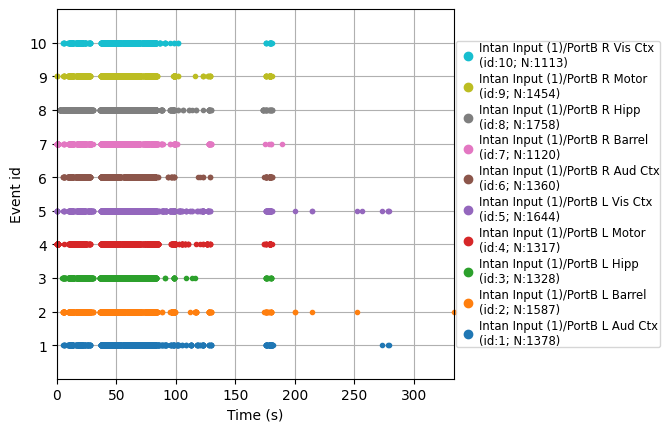

In [ ]:
events = mne.events_from_annotations(raw=mne_obj)

fig = mne.viz.plot_events(events[0], sfreq=mne_obj.info['sfreq'], first_samp=mne_obj.first_samp, event_id=events[1])


In [20]:
# tfr_spike, tfr_baseline = analyze_peri_spike_tfr(mne_obj, tmin=-1, tmax=1)